In [2]:
import pandas as pd
import os


# display(df)

In [7]:
# FOR IF EVAL
results_dir = "eval_results"
# experiment = "templating"
experiment = "baseline_embeddings"
results_file_name = "eval_results.csv"

results_file = os.path.join(results_dir, experiment, results_file_name)

df = pd.read_csv(results_file)
print(len(df))

main_results = df[df["alias"] == "ifeval"]
main_results.fillna("NAN", inplace=True)
# main_results = main_results[main_results["limit"] == "NAN"]
main_results["task_name"].replace("ifeval", "baseline", inplace=True)

def get_aggregated_results(result_df: pd.DataFrame, column: list[str]) -> pd.DataFrame:
    aggregated_results = result_df.groupby(column).agg({
        "prompt_level_strict_acc": ["mean", "std", "count", "max"],
        "compression_ratio": ["mean"],
        "learning_ratio": ["mean"],
        "theoretical_compression_ratio": ["mean"],
    })
    return aggregated_results

# main_results.sort_values(by="exact_match", ascending=True)
main_results.sort_values(by="prompt_level_strict_acc", ascending=True)


8


/cmlscratch/astein0/tmp/ipykernel_3343847/259274487.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NAN' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  main_results.fillna("NAN", inplace=True)
/cmlscratch/astein0/tmp/ipykernel_3343847/259274487.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_results["task_name"].replace("ifeval", "baseline", inplace=True)


,model_name_sanitized,model_name,task_name,exact_match,exact_match_stderr,prompt_level_strict_acc,prompt_level_strict_acc_stderr,inst_level_strict_acc,inst_level_strict_acc_stderr,prompt_level_loose_acc,prompt_level_loose_acc_stderr,inst_level_loose_acc,inst_level_loose_acc_stderr,compression_ratio,learning_ratio,theoretical_compression_ratio,alias,limit,json_path,finetuning_params,total_batch_size,learning_rate,main_loss_type,embedding_init_strategy,num_new_tokens,unfreeze_params_steps,finetune_params_prefreeze,dataset,tokenizer_path,seed,reset_optimizer,warmup_steps,lr_schedule,warmup_steps_prefreeze,lr_schedule_prefreeze
0,output__baseline_embeddings__e08a94c1-Llama-3....,Llama-3.2-3B,mixed,NAN,NAN,0.146026,0.015196,0.268585,NAN,0.157116,0.015660,0.282974,NAN,0.092089,0.035668,0.121196,ifeval,NAN,eval_results/baseline_embeddings/output__basel...,embeddings,32.0,0.0005,mixed,merge,1000.0,-1.0,NAN,"magpie-default-tokenized_1000,magpie-translati...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,250.0,cosine,-1.0,NAN
1,output__baseline_embeddings__e08a94c1-Llama-3....,Llama-3.2-3B,mixed,NAN,NAN,0.146026,0.015196,0.268585,NAN,0.157116,0.015660,0.282974,NAN,0.092089,0.035668,0.121196,ifeval,NAN,eval_results/baseline_embeddings/output__basel...,embeddings,32.0,0.0005,mixed,merge,1000.0,-1.0,NAN,"magpie-default-tokenized_1000,magpie-translati...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,250.0,cosine,-1.0,NAN
3,output__baseline_embeddings__b9ece787-Llama-3....,Llama-3.2-3B,mixed,NAN,NAN,0.151571,0.015432,0.286571,NAN,0.170055,0.016167,0.309353,NAN,0.052622,0.003585,0.056305,ifeval,NAN,eval_results/baseline_embeddings/output__basel...,embeddings,32.0,0.0005,mixed,merge,100.0,-1.0,NAN,"magpie-default-tokenized_100,magpie-translatio...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,250.0,cosine,-1.0,NAN
4,output__baseline_embeddings__b9ece787-Llama-3....,Llama-3.2-3B,mixed,NAN,NAN,0.155268,0.015585,0.288969,NAN,0.170055,0.016167,0.309353,NAN,0.052622,0.003585,0.056305,ifeval,NAN,eval_results/baseline_embeddings/output__basel...,embeddings,32.0,0.0005,mixed,merge,100.0,-1.0,NAN,"magpie-default-tokenized_100,magpie-translatio...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,250.0,cosine,-1.0,NAN
5,output__baseline_embeddings__75ec96b0-Llama-3....,Llama-3.2-3B,mixed,NAN,NAN,0.166359,0.016026,0.293765,NAN,0.188540,0.016832,0.314149,NAN,-0.024244,0.071399,0.015821,ifeval,NAN,eval_results/baseline_embeddings/output__basel...,embeddings,32.0,0.0005,mixed,merge,10.0,-1.0,NAN,"magpie-default-tokenized_10,magpie-translation...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,250.0,cosine,-1.0,NAN
6,output__baseline_embeddings__75ec96b0-Llama-3....,Llama-3.2-3B,mixed,NAN,NAN,0.166359,0.016026,0.293765,NAN,0.188540,0.016832,0.314149,NAN,-0.024244,0.071399,0.015821,ifeval,NAN,eval_results/baseline_embeddings/output__basel...,embeddings,32.0,0.0005,mixed,merge,10.0,-1.0,NAN,"magpie-default-tokenized_10,magpie-translation...",/cmlscratch/astein0/efficient_tokenization_for...,1234.0,False,250.0,cosine,-1.0,NAN
7,output__baseline_embeddings__838db6d0-Llama-3....,Llama-3.2-3B,mixed,NAN,NAN,0.182994,0.016639,0.310552,NAN,0.205176,0.017378,0.328537,NAN,-0.008277,0.011175,0.000000,ifeval,NAN,eval_results/baseline_embeddings/output__basel...,embeddings,32.0,0.0005,mixed,NAN,0.0,-1.0,NAN,"magpie-default-tokenized_0,magpie-translation-...",meta-llama/Llama-3.2-3B-Instruct,1234.0,False,250.0,cosine,-1.0,NAN
2,meta-llama__Llama-3.2-3B,meta-llama,baseline,NAN,NAN,0.207024,0.017436,0.333333,NAN,0.223660,0.017932,0.357314,NAN,0.001626,0.002928,0.000000,ifeval,NAN,eval_results/baseline_embeddings/meta-llama__L...,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN,NAN


In [4]:
# Display all rows
pd.set_option('display.max_rows', None)

# Display all columns
pd.set_option('display.max_columns', None)

# # Display full column width
# pd.set_option('display.max_colwidth', -1)

In [8]:
agg_col = [ "num_new_tokens", "task_name"]
display(get_aggregated_results(main_results, agg_col))

prompt_level_strict_acc                            \
                                            mean       std count       max   
num_new_tokens task_name                                                     
0.0            mixed                    0.182994       NaN     1  0.182994   
10.0           mixed                    0.166359  0.000000     2  0.166359   
100.0          mixed                    0.153420  0.002614     2  0.155268   
1000.0         mixed                    0.146026  0.000000     2  0.146026   
NAN            baseline                 0.207024       NaN     1  0.207024   

                         compression_ratio learning_ratio  \
                                      mean           mean   
num_new_tokens task_name                                    
0.0            mixed             -0.008277       0.011175   
10.0           mixed             -0.024244       0.071399   
100.0          mixed              0.052622       0.003585   
1000.0         mixed              0.092089       0.035668   
NAN            baseline           0.001626       0.002928   

                         theoretical_compression_ratio  
                                                  mean  
num_new_tokens task_name                                
0.0            mixed                          0.000000  
10.0           mixed                          0.015821  
100.0          mixed                          0.056305  
1000.0         mixed                          0.121196  
NAN            baseline                       0.000000

# aggregate results by task name

In [10]:
agg_col = ["task_name", "num_new_tokens"]
tasks = get_aggregated_results(main_results, agg_col)
display(tasks)
tasks.to_csv("tables/task_name.csv", sep=",")

exact_match                        
                                  mean       std count     max
task_name   num_new_tokens                                    
SFT         0.0               0.027533  0.017279     3  0.0420
            10.0              0.017367  0.012575    12  0.0324
baseline    NAN               0.012800       NaN     1  0.0128
translation 10.0              0.005478  0.004622    18  0.0178

# Aggregate results by learning rate (and total batch size)

In [5]:
agg_col = ["learning_rate", "total_batch_size", "num_new_tokens"]
lr = get_aggregated_results(main_results, agg_col)
display(lr)
lr.to_csv("tables/learning_rate.csv", sep=",")

exact_match                  \
                                                     mean       std count   
learning_rate total_batch_size num_new_tokens                               
0.00001       64.0             10.0              0.007267  0.006192     6   
0.00002       64.0             10.0              0.006467  0.004302     6   
0.00004       64.0             0.0               0.032200       NaN     1   
                               10.0              0.013680  0.014246    10   
0.00008       128.0            0.0               0.042000       NaN     1   
                               10.0              0.020000  0.004564     4   
0.00016       256.0            0.0               0.008400       NaN     1   
                               10.0              0.001950  0.003376     4   
NAN           NAN              NAN               0.012800       NaN     1   

                                                       
                                                  max  
learning_rate total_batch_size num_new_tokens          
0.00001       64.0             10.0            0.0178  
0.00002       64.0             10.0            0.0108  
0.00004       64.0             0.0             0.0322  
                               10.0            0.0324  
0.00008       128.0            0.0             0.0420  
                               10.0            0.0260  
0.00016       256.0            0.0             0.0084  
                               10.0            0.0070  
NAN           NAN              NAN             0.0128

# Aggregate results by extending strategy

In [9]:
agg_col = ["model_name", "embedding_init_strategy", "finetuning_params", "unfreeze_params_steps"]
embed = main_results[main_results["num_new_tokens"] == 10]
# embed = embed[embed["total_batch_size"] == 64]
embed = get_aggregated_results(embed, agg_col)
display(embed)
embed.to_csv("tables/embedding.csv", sep=",")

exact_match  \
                                                                                    mean   
model_name   embedding_init_strategy finetuning_params unfreeze_params_steps               
Llama-3.2-1B default                 full              -1.0                     0.020533   
             mean                    embeddings        -1.0                     0.007467   
                                                        1000.0                  0.005400   
                                     full              -1.0                     0.008833   
             merge                   embeddings        -1.0                     0.009933   
                                                        1000.0                  0.006600   
                                     full              -1.0                     0.009700   
             zeros                   full              -1.0                     0.015333   

                                                                                        \
                                                                                   std   
model_name   embedding_init_strategy finetuning_params unfreeze_params_steps             
Llama-3.2-1B default                 full              -1.0                   0.011792   
             mean                    embeddings        -1.0                   0.004562   
                                                        1000.0                0.002750   
                                     full              -1.0                   0.012956   
             merge                   embeddings        -1.0                   0.008334   
                                                        1000.0                0.001637   
                                     full              -1.0                   0.013044   
             zeros                   full              -1.0                   0.014292   

                                                                                    \
                                                                             count   
model_name   embedding_init_strategy finetuning_params unfreeze_params_steps         
Llama-3.2-1B default                 full              -1.0                      3   
             mean                    embeddings        -1.0                      3   
                                                        1000.0                   3   
                                     full              -1.0                      6   
             merge                   embeddings        -1.0                      3   
                                                        1000.0                   3   
                                     full              -1.0                      6   
             zeros                   full              -1.0                      3   

                                                                                      
                                                                                 max  
model_name   embedding_init_strategy finetuning_params unfreeze_params_steps          
Llama-3.2-1B default                 full              -1.0                   0.0286  
             mean                    embeddings        -1.0                   0.0102  
                                                        1000.0                0.0084  
                                     full              -1.0                   0.0324  
             merge                   embeddings        -1.0                   0.0178  
                                                        1000.0                0.0080  
                                     full              -1.0                   0.0310  
             zeros                   full              -1.0                   0.0286

# chart performance by num_new_tokens


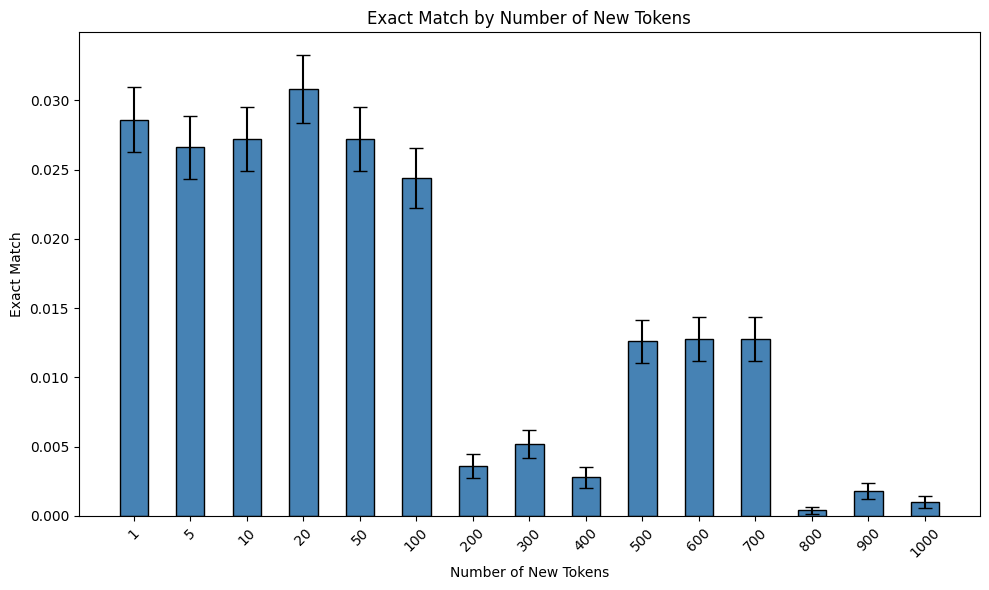

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert "num_new_tokens" to integers and sort the DataFrame
main_results_sorted = main_results.copy()
main_results_sorted["num_new_tokens"] = main_results_sorted["num_new_tokens"].astype(int)
main_results_sorted = main_results_sorted.sort_values(by="num_new_tokens")

# Extract sorted values
x = main_results_sorted["num_new_tokens"].astype(str)  # Convert to string for plotting
y = main_results_sorted["exact_match"]
yerr = main_results_sorted["exact_match_stderr"]

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, y, yerr=yerr, capsize=5, color='steelblue', edgecolor='black', width=0.5)

# Add labels and formatting
ax.set_xlabel('Number of New Tokens')
ax.set_ylabel('Exact Match')
ax.set_title('Exact Match by Number of New Tokens')

plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()


In [12]:
print(sns.__version__)

0.13.2
